(week4:coords)=
# Geographic coordinate systems

The pamphlet:

[Understanding map projections](https://clouds.eos.ubc.ca/~phil/courses/eosc582/downloads/understanding_map_projections.pdf)

Introduces geographic coordinate systems in Chapter 1.  They solve the problem of how to locate yourself on the earth's surface in three dimensions.  They specify an angular measure of units, a prime meridian, a spheroid and a datam (see chapter 1).

## Basic points

We need to define two fundamental things:

1.  A "[datum](https://www.maptools.com/tutorials/map_datum)"  (called a "globe" in cartopy) that gives the three dimensional shape of the earth (and other things)

1.  A "[projection](https://en.wikipedia.org/wiki/List_of_map_projections)" that maps a point on the earth's surface onto an x-y coordinate system to make a 2-dimensional plot.

1.  Our mapping module is called [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html).  Internally, it uses projection code in [pyproj](https://github.com/jswhit/pyproj), which in turn is a wrapper around C code called
[proj4](https://proj4.org/usage/projections.html)

## An example

The [Equal Area Scalable Earth Grid](https://nsidc.org/data/ease)

1. Datum: The original EASE grid assumed a spherical earth with a radius of 6371.228 km.  [EASE-2](https://nsidc.org/data/ease/versions.html) uses a datum called [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System)

1. Both EASE and EASE-2 use the [Lambert Azimuthal Equal Area](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) or LAEA

$# Map projections

Chapter 2 describes map projections.  We will generally be using the LAEA projection for individual Modis granules.

### plotting Vancouver on a map


* Step 1: Use [cartopy](http://scitools.org.uk/cartopy/docs/latest/index.html) to make a LAEA map of BC including Vancouver.

In [1]:
import a301_lib
from pathlib import Path
from pyhdf.SD import SD, SDC
from matplotlib import pyplot as plt
import sat_lib.modismeta_read as mread
import pprint
import h5py
from sat_lib.modismeta_read import get_core, parseMeta

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init


In [2]:
myd03_dir = a301_lib.sat_data / "h5_dir"
geom_file_name = list(myd03_dir.glob("geom*MYD03*2105*h5"))[0]
#breakpoint()
print(geom_file_name)

/home/phil/work/sat_data/h5_dir/geom_MYD03.A2013222.2105.006.2013223155808.h5


*  What's in the file?

In [3]:
with h5py.File(geom_file_name,'r') as f:
    print(list(f.keys()))
    geom_group = f['geometry']
    print(list(geom_group.keys()))
    lats = geom_group['latitude'][...]
    print(lats.shape)
    lons = geom_group['longitude'][...]
    print(lons.shape)
    print(f.attrs.keys())
    core_metadata = f.attrs["CoreMetadata.0"]
    swath_info = parseMeta(core_metadata)

['geometry']
['latitude', 'longitude']
(2040, 1354)
(2040, 1354)
<KeysViewHDF5 ['CoreMetadata.0', 'history']>


* Read the MYD03 metadata into a dictionary

This uses some fancy code I wrote, treat as a black box for now. Later on we will want to define  a region that just includes the whole swath.  This is given by the [min_lon, max_lon, min_lat, max_lat] points.  The actual corners of the swath are given by lat_list and lon_list.  The center of the swath is given by lon_0,lat_0

* Read the lats and lons into array

*  Note the overlap in the 10 scanlines

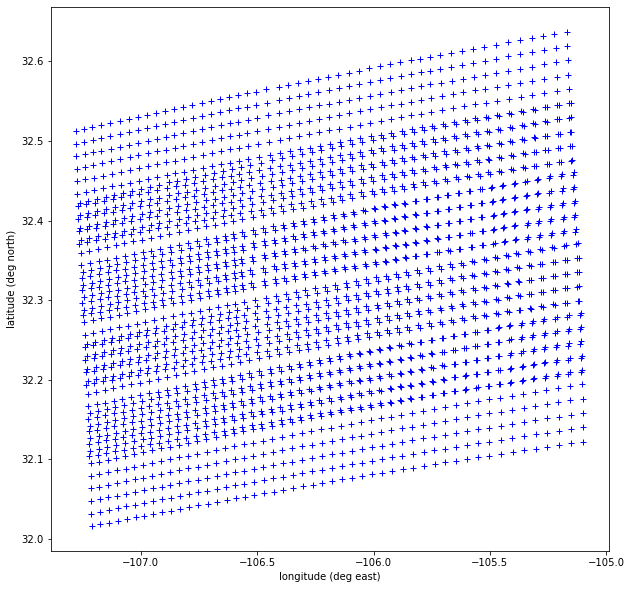

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(lons[:50,:50],lats[:50,:50],"b+")
ax.set(xlabel="longitude (deg east)",ylabel="latitude (deg north)");

*  Now choose the Lambert project for our map

**This cell sets up the datum and the LAEA projection, with the tangent point at the North Pole and the central meridian at -90 degrees west of Greenwich**

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np

#
# Datum: radius of the earth in meters
#
radius = 6_371_228

#
# vancouver longitude, latitude indegrees
#
van_lon, van_lat = [-123.1207, 49.2827]
#
# use a simple sphere as the datum
#
globe = ccrs.Globe(ellipse=None, semimajor_axis=radius, semiminor_axis=radius)
#
# set up
#
projection = ccrs.LambertAzimuthalEqualArea(
    central_latitude=90, central_longitude=-90, globe=globe
)
print(f"pro4 program params: {projection.proj4_params}")

pro4 program params: {'a': 6371228, 'b': 6371228, 'proj': 'laea', 'lon_0': -90, 'lat_0': 90, 'x_0': 0.0, 'y_0': 0.0}


**Use matplotlib to draw the map and add a coastline**

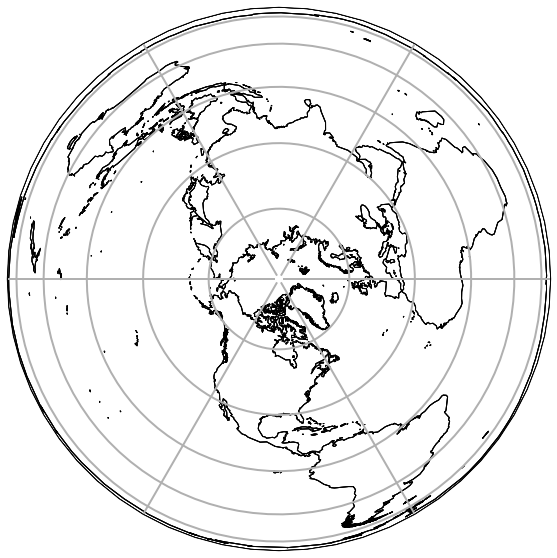

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": projection})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))

*  zoom in on vancouver

The next step is to pick an bounding box in map coordinates (the "extent") to limit the map area

The idea is to reduce the extent of the map to a region that is only a fraction
of the original full globe.  The strategy is to find a point in your swath and
get it's x,y coords, then use that to set the corners of the map so that
you have your region of interest

In [7]:
#
# pick a bounding box in map coordinates
# (we know from the next cell that vancouver is located
# at x,y = -2_422_235, -3_721_768  so pick a bounding box
# based on that
#
xleft, xright = -4_000_000, -800_000
ybot, ytop = -4_700_000, -3_100_000

* Use the transform_point method to get x,y on this projection

This is how we put Vancouver (in lon,lat coords) on the map (in LAEA x,y coords)

-2422235.2316723852 -3712768.5862524547


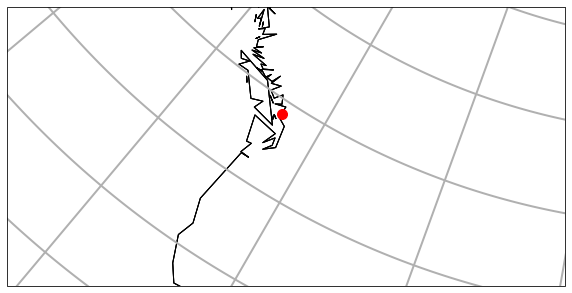

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": projection})
#
# clip with 0,0 in the center:  [xleft, xright, ybot, ytop]
#
new_extent = [xleft, xright, ybot, ytop]
ax.set_extent(new_extent, projection)
#
# the simple lon,lat projection is called "geodetic"
#
geodetic = ccrs.Geodetic()
van_x, van_y = projection.transform_point(van_lon, van_lat, geodetic)
ax.plot(van_x, van_y, "ro", markersize=10)
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
print(van_x, van_y);

* saving the figure

Since we have created a figure object, we can use that to save the png file
using the same syntax as [Kazarinoff 7.4](https://atsc_web.eoas.ubc.ca/Plotting-with-Matplotlib/Saving-Plots.html)

In [9]:
png_file = a301_lib.data_share / 'pha_map.png'
fig.savefig(png_file)

To check to see if your file has arrived, open the jupyterhub tab [https://a301_hub.eoas.ubc.ca](https://a301_hub.eoas.ubc.ca) and check the contents of the `data_share` folder.  Click on the "last modified" column twice to bring receint files to the top of the list.